In [ ]:
%pip install tensorflow

In [2]:
import pandas as pd
import numpy as np
import json
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
import sys
sys.path.append("../utils")
from utils import load_csv
import joblib

import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [3]:
def create_dataset(dataset, time_step = 50):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        dataX.append(dataset[i:(i+time_step),0])
        dataY.append(dataset[i+time_step, 0])
    return np.array(dataX), np.array(dataY)

In [ ]:
def train_lstm(symbol, time_step=100):
    df = load_csv(f"../../data/features/{symbol}_features.csv")
    df.index = df.date
    df.drop('date', axis=1,inplace=True)
    df = df.reset_index()['close']

    # chuẩn hoá dữ liệu
    scaler = MinMaxScaler(feature_range=(0, 1))
    close_scaled = scaler.fit_transform(np.array(df).reshape(-1,1))
    joblib.dump(scaler, f"../../model/{symbol}_lstm_scaler.pkl")

    split_index = int(len(close_scaled)*0.7)
    train_data, test_data = close_scaled[:split_index], close_scaled[split_index:]

    X_train, y_train = create_dataset(train_data, time_step)
    X_test, y_test = create_dataset(test_data, time_step)
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

    model = Sequential()
    model.add(Input(shape=(time_step, 1)))
    model.add(LSTM(128, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(64, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(32))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.summary()

    model_path = f"../../model/{symbol}_lstm_model.keras"
        # Lưu mô hình khi val_loss tốt hơn
    best_model = ModelCheckpoint(
        filepath=model_path,
        monitor='val_loss',
        verbose=1,
        save_best_only=True,
        mode='min'
    )

    # Dừng sớm nếu val_loss không cải thiện trong 20 epoch
    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=20,
        restore_best_weights=True,
        verbose=1
    )

    model.fit(
        X_train,
        y_train,
        epochs=100,
        batch_size=64,
        verbose = 1,
        validation_data=(X_test, y_test),
        callbacks=[best_model, early_stop]
    )
    return X_train, y_train, X_test, y_test, close_scaled, scaler, df


In [14]:
def evaluate_lstm(symbol, X_train, X_test, y_test, close_scaled, scaler, df, time_step=100):
    model_path = f"../../model/{symbol}_lstm_model.keras"
    final_model = load_model(model_path)

    train_predict = final_model.predict(X_train)
    test_predict = final_model.predict(X_test)

    train_predict = scaler.inverse_transform(train_predict)
    test_predict = scaler.inverse_transform(test_predict)
    dates = df.index

    trainPredictPlot = np.empty_like(close_scaled)
    trainPredictPlot[:, :] = np.nan
    trainPredictPlot[time_step:len(train_predict)+time_step, :] = train_predict
    
    testPredictPlot = np.empty_like(close_scaled)
    testPredictPlot[:, :] = np.nan
    testPredictPlot[len(train_predict)+(time_step*2)+1:len(close_scaled)-1, :] = test_predict

    plt.figure(figsize=(14,5))
    plt.plot(scaler.inverse_transform(close_scaled), color='b', label='Original Data')
    plt.plot(trainPredictPlot, color='g', label='Train Predict')
    plt.plot(testPredictPlot, color='r', label='Test Predict')
    plt.ylabel('Close Price')
    plt.title(f'{symbol.upper()} Stock Price Prediction')
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"../../output/images/lstm_prediction_{symbol}.png")
    plt.show()
    plt.close()

    y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

    mae = mean_absolute_error(y_test_inv, test_predict)
    rmse = np.sqrt(mean_squared_error(y_test_inv, test_predict))
    mape = np.mean(np.abs((y_test_inv - test_predict) / y_test_inv)) * 100
    r2 = r2_score(y_test_inv, test_predict)

    return {
        "MAE": round(mae, 2),
        "RMSE": round(rmse, 2),
        "MAPE": round(mape, 2),
        "R²": round(r2, 2)
    }


2025-06-08 03:21:20,366 - INFO - ✅ Load CSV thành công: ../../data/features/fpt_features.csv | shape = (4521, 13)


⏳ Huấn luyện LSTM cho FPT ...
Epoch 1/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - loss: 4.8444e-04
Epoch 1: val_loss improved from inf to 0.00338, saving model to ../../model/fpt_lstm_model.keras
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 132ms/step - loss: 4.7886e-04 - val_loss: 0.0034
Epoch 2/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - loss: 5.4500e-05
Epoch 2: val_loss improved from 0.00338 to 0.00265, saving model to ../../model/fpt_lstm_model.keras
48/48 ━━━━━━━━━━━━━━━━━━━━ 6s 118ms/step - loss: 5.4402e-05 - val_loss: 0.0026
Epoch 3/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - loss: 4.2141e-05
Epoch 3: val_loss improved from 0.00265 to 0.00260, saving model to ../../model/fpt_lstm_model.keras
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 161ms/step - loss: 4.2096e-05 - val_loss: 0.0026
Epoch 4/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - loss: 3.7918e-05
Epoch 4: val_loss improved from 0.00260 to 0.00091, saving model to ../../model/fpt_lstm_model.keras
48/48 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - lo

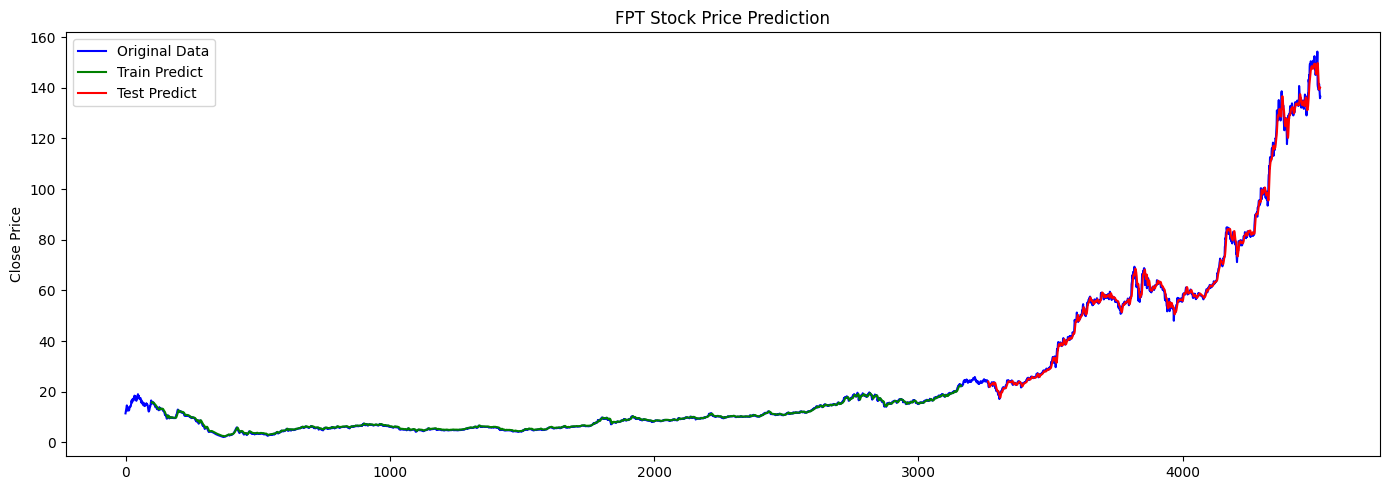

2025-06-08 03:33:45,376 - INFO - ✅ Load CSV thành công: ../../data/features/hpg_features.csv | shape = (4318, 13)


✅ Hoàn tất FPT
⏳ Huấn luyện LSTM cho HPG ...
Epoch 1/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - loss: 0.0033
Epoch 1: val_loss improved from inf to 0.00342, saving model to ../../model/hpg_lstm_model.keras
46/46 ━━━━━━━━━━━━━━━━━━━━ 12s 183ms/step - loss: 0.0032 - val_loss: 0.0034
Epoch 2/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - loss: 2.5442e-04
Epoch 2: val_loss did not improve from 0.00342
46/46 ━━━━━━━━━━━━━━━━━━━━ 7s 146ms/step - loss: 2.5534e-04 - val_loss: 0.0061
Epoch 3/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - loss: 3.0978e-04
Epoch 3: val_loss did not improve from 0.00342
46/46 ━━━━━━━━━━━━━━━━━━━━ 7s 147ms/step - loss: 3.0960e-04 - val_loss: 0.0047
Epoch 4/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - loss: 2.9309e-04
Epoch 4: val_loss improved from 0.00342 to 0.00337, saving model to ../../model/hpg_lstm_model.keras
46/46 ━━━━━━━━━━━━━━━━━━━━ 7s 145ms/step - loss: 2.9252e-04 - val_loss: 0.0034
Epoch 5/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - loss: 2.663

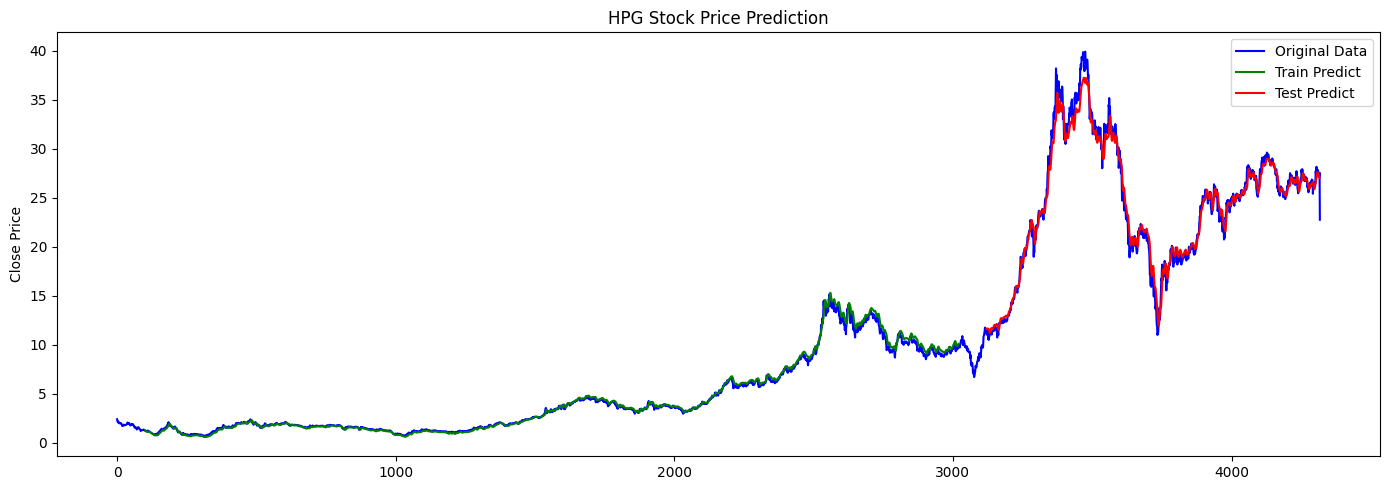

2025-06-08 03:42:15,580 - INFO - ✅ Load CSV thành công: ../../data/features/vnm_features.csv | shape = (4753, 13)


✅ Hoàn tất HPG
⏳ Huấn luyện LSTM cho VNM ...
Epoch 1/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - loss: 0.0282
Epoch 1: val_loss improved from inf to 0.00072, saving model to ../../model/vnm_lstm_model.keras
51/51 ━━━━━━━━━━━━━━━━━━━━ 11s 149ms/step - loss: 0.0279 - val_loss: 7.2442e-04
Epoch 2/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - loss: 0.0024
Epoch 2: val_loss improved from 0.00072 to 0.00055, saving model to ../../model/vnm_lstm_model.keras
51/51 ━━━━━━━━━━━━━━━━━━━━ 8s 147ms/step - loss: 0.0024 - val_loss: 5.5482e-04
Epoch 3/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - loss: 0.0020
Epoch 3: val_loss did not improve from 0.00055
51/51 ━━━━━━━━━━━━━━━━━━━━ 7s 140ms/step - loss: 0.0020 - val_loss: 0.0030
Epoch 4/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - loss: 0.0024
Epoch 4: val_loss improved from 0.00055 to 0.00049, saving model to ../../model/vnm_lstm_model.keras
51/51 ━━━━━━━━━━━━━━━━━━━━ 7s 141ms/step - loss: 0.0024 - val_loss: 4.9121e-04
Epoch 5/100
51/51 ━━━━━━

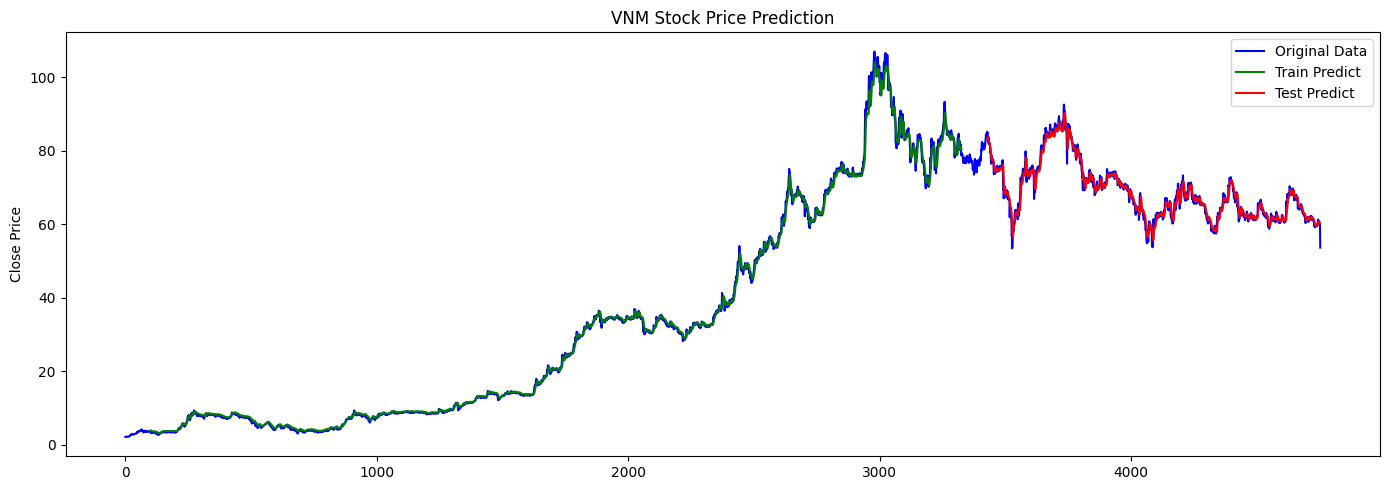

✅ Hoàn tất VNM


In [15]:
symbols = ["fpt", "hpg", "vnm"]
results = []

for symbol in symbols:
    print(f"⏳ Huấn luyện LSTM cho {symbol.upper()} ...")
    X_train, y_train, X_test, y_test, close_scaled, scaler, df = train_lstm(symbol)
    metrics = evaluate_lstm(symbol, X_train, X_test, y_test, close_scaled, scaler, df)
    with open(f"../../output/metrics/lstm_{symbol}_metrics.json", "w", encoding="utf-8") as f:
        json.dump(metrics, f, indent=4)
    print(f"✅ Hoàn tất {symbol.upper()}")
